In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.models.gpt2.modeling_gpt2 import *
from data_collection import training_set
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

/home/linulun/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
if not os.path.isfile("dataset.p"):
    train_dataset = training_set(["romantic", "friendly", "fight"], tokenizer)
    pickle.dump(train_dataset, open("dataset.p", "wb"))
else:
    train_dataset = pickle.load(open("dataset.p", "rb"))
    
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [5]:
for param in gpt2_model.parameters():
    param.requires_grad = False
for param in gpt2_model.lm_head.parameters():
    param.requires_grad = True

In [7]:
save_name = "dialogue_model.p"

In [8]:
# load model
trained_model_data = pickle.load(open(save_name, "rb"))
state_dict = trained_model_data["state_dict"]
gpt2_model.load_state_dict(state_dict)
epoch_losses = trained_model_data["loss"]

In [6]:
epoch_losses = []

In [6]:
optimizer = torch.optim.Adam(gpt2_model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpt2_model = gpt2_model.to(device)

epochs = 3

pb = tqdm.tqdm(total=epochs * len(train_loader))

for epoch in range(epochs):
    epoch_loss = 0
    for sequence in train_loader:
        sequence = sequence.to(device)

        optimizer.zero_grad()   
        
        loss, logits = gpt2_model(sequence, labels=sequence)[:2]
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pb.update(1)
    
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch} loss: {epoch_loss}")

pickle.dump({ "state_dict": gpt2_model.state_dict(), "loss": epoch_losses },
            open(save_name, "wb"))

  0%|          | 0/26502 [00:00<?, ?it/s]c:\Users\linus\anaconda3\envs\main\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 33%|███▎      | 8834/26502 [1:28:33<2:56:54,  1.66it/s]

Epoch 0 loss: 6279.058181583881


 67%|██████▋   | 17668/26502 [2:56:59<1:28:26,  1.66it/s]

Epoch 1 loss: 6126.6199952065945


100%|██████████| 26502/26502 [4:25:27<00:00,  1.66it/s]  

Epoch 2 loss: 6028.793759286404


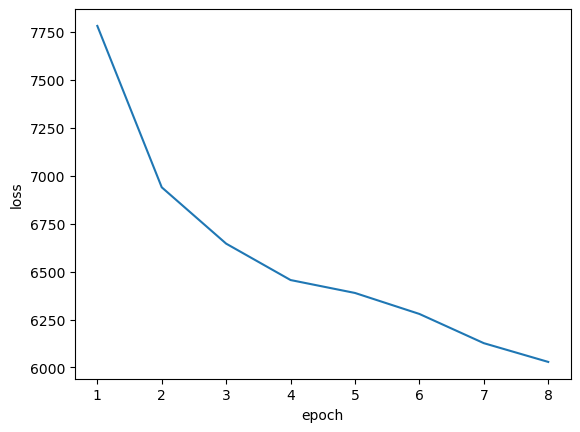

In [13]:
plt.plot(np.arange(len(epoch_losses)) + 1, epoch_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()